# Aim
The aim of this final project is two folded:
1. Visualisation of a particular stock using different indicators.
2. Utilisation of various machine learning models to predict the price movement of the stock.

# Content

## 1. Data Collection
- Use Alpha Vantage to fetch live stock data 

## 2. Features Addition
- Add financial indicators like Bollinger Bands, MACD, RSI to the dataframe

## 3. Indicators
- Create gauge charts to measure market sentiment, news sentiment and 52-week range.

## 4. Machine Learning
- Apply two machine learning learning models (Random Forest and LSTM) to predict the stock price movement in 2019 with the usage of 2013-2018 data

## 1. Data Collection


In order to perform individual stock price analysis, one can extract the relevant price information from [here](https://www.alphavantage.co/documentation/)

Additional documentation for the usage of pandas_datareader [click here](https://buildmedia.readthedocs.org/media/pdf/pandas-datareader/latest/pandas-datareader.pdf)

In [1]:
# import my API code

import getpass

password = getpass.getpass()

#import main dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

········


In [2]:
# ask the user to provide the name of the company
company_name=input("Enter company name")

Enter company nameFacebook


In [3]:
def financial_data(ticker, password):
    """
    Using the API method to fetch data of an individual stock.
    
    Input: the ticker name
    
    Returns: a dataframe consists of date, open, close, high, low, adjusted close, volume 
    """
    
    # 1. Import the relevant libraries

    import pandas as pd
    import numpy as np
    import matplotlib.dates as mdates
    import matplotlib.pyplot as plt

    import seaborn as sns
    sns.set_style('whitegrid')  # Give nice white background with grid
    %matplotlib inline
    import plotly.express as px

    pd.set_option("display.max_rows", 1000)
    pd.set_option("display.max_columns", 100)

    from datetime import datetime

    from matplotlib.offsetbox import AnchoredText


    # Additionally, these two modules are imported in order to extract the information from the above website by using the API
    import os
    import pandas_datareader.data as web
    
    import requests
    from matplotlib import style

    data=requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&outputsize=full&apikey={password}')
    data=data.json()
    data=data['Time Series (Daily)']
    
    # These codes are used in order to set xticks in the plt graph into individual months 
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')
    
    
    # 2. Create a df to store the elementary dataset and data type conversion
    df=pd.DataFrame(columns=['date','open','high','low','close','adjusted close','volume','dividend amount','split coefficient'])

    for d,p in data.items():
        date=datetime.strptime(d,'%Y-%m-%d')
        data_row=[date,float(p['1. open']),float(p['2. high']),float(p['3. low']),float(p['4. close']),float(p['5. adjusted close']),float(p['6. volume']),float(p['7. dividend amount']),float(p['8. split coefficient'])]
        df.loc[-1,:]=data_row
        df.index=df.index+1
    
    # Convert all numerical columns to float
    for i in list(df.columns)[1:]:
        df[i]=df[i].astype(float)
    # Convert date to datetime object
    df["date"] = pd.to_datetime(df["date"])
    # Sort the date in ascending order
    df= df.sort_values(by=["date"])
    
    # drop unnecessary columns
    df = df.drop(columns=["dividend amount","split coefficient"])
    return df

In [4]:
Facebook = financial_data("FB",password)

### Explore the dataset

In [5]:
Facebook.dtypes

date              datetime64[ns]
open                     float64
high                     float64
low                      float64
close                    float64
adjusted close           float64
volume                   float64
dtype: object

In [6]:
Facebook.describe()

,open,high,low,close,adjusted close,volume
count,1905.000000,1905.000000,1905.000000,1905.000000,1905.000000,1.905000e+03
mean,108.980013,110.137798,107.766328,108.996030,108.996030,3.346388e+07
std,56.533656,56.989696,56.068833,56.576722,56.576722,3.001547e+07
min,18.080000,18.270000,17.550000,17.729000,17.729000,5.913066e+06
25%,63.230000,63.650000,62.150000,62.880000,62.880000,1.637129e+07
50%,109.110000,110.330000,107.950000,109.010000,109.010000,2.417926e+07
75%,164.570000,166.240000,162.810000,164.620000,164.620000,4.091490e+07
max,215.715000,218.620000,214.270000,217.500000,217.500000,5.735764e+08


In [7]:
Facebook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1905 entries, 0 to 1904
Data columns (total 7 columns):
date              1905 non-null datetime64[ns]
open              1905 non-null float64
high              1905 non-null float64
low               1905 non-null float64
close             1905 non-null float64
adjusted close    1905 non-null float64
volume            1905 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 119.1 KB


## 2. Features addition

In [8]:
def open_close(df):
# Add open/close to df
    df["open/close"]=df["open"]/df["adjusted close"]
    


In [9]:
def volatility_feature(df):
    '''
    Use ta module to calculate the bollinger Bands and average true range (ATR) of the corresponding stocks
    
    Input: df containing high, low, adjusted close prices and the dates
    
    Return: a process to create a new df with additional 3 additional bollinger bands and 1 ATR columns
    
    '''
    
    import ta
    # import bollinger bands
    
    # Initialize Bollinger Bands Indicator
    indicator_bb = ta.volatility.BollingerBands(close=df["adjusted close"], n=20, ndev=2)

    # Add Bollinger Bands features
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()
    
    # import ATR (Average True Range)
    
    # Initialize ATR
    ATR = ta.volatility.AverageTrueRange(high=df["high"],low=df["low"],close=df["adjusted close"], n=14)
    
    df["ATR"] = ATR.average_true_range()


In [10]:
def SMA_feature(df):
    '''
    Calculate the Simple Moving Average (SMA) of the corresponding stocks
    
    Input: df containing adjusted close price and the dates
    
    Return: a process to create a new df with additional 3 additional SMA columns
    
    '''
    import pandas as pd
    import numpy as np
    # Add simple moving average (SMA) to df

    ma_day = [10,20,50]

    for ma in ma_day:
        column_name = f"SMA_{ma}"

        df[column_name] = df['adjusted close'].rolling(ma).mean()

In [90]:
def candlestick_graph(df):
    """
    Create a candlestick graph for the given period of the stock. Has dependency on SMA_feature. The df must be run by SMA_feature first
    
    Input: df containing open,high, low, adjusted close prices and the dates
    
    Return: A candlestick graph of the corresponding stocks
    """
    
    # ask the user to provide the name of the company
    company_name=input("Enter company name")
    
    # import essential modules
    import pandas as pd
    import numpy as np
    import plotly.express as px
    import plotly.graph_objects as go

    fig = go.Figure()
    # Plot the candlestick graph and the other trendlines (MAs)
    fig.add_trace(go.Candlestick(x=df["date"],
                    open=df["open"], high=df["high"],
                    low=df["low"], close=df["adjusted close"],name="Adjusted Price"))
    fig.add_trace(go.Scatter(x=df["date"], y=df["adjusted close"],name="price",line = dict(width = 1, color="lightblue"),mode="lines"))
    fig.add_trace(go.Scatter(x=df["date"], y=df["SMA_20"], name="SMA_20",line = dict(color='royalblue',width = 1.5),mode="lines"))
    fig.add_trace(go.Scatter(x=df["date"], y=df["SMA_50"],name="SMA_50",line = dict(color='burlywood',width = 1.5),mode="lines"))

    # Manually enlarging the graph and adding title for the graph
    fig.update_layout(autosize= False, width =1000, height=500,title=f"{company_name} Candlestick Graph from {df['date'].iloc[0].strftime('%b %Y')} to {df['date'].iloc[-1].strftime('%b %Y')} ", showlegend=True) 

    # Add monthly ticks in x-axis
    fig.layout.xaxis.tickvals = pd.date_range(df["date"].iloc[0], df["date"].iloc[-1], freq='3M')
    fig.layout.xaxis.tickformat = '%b %y'

    # Not showing rangeslider
    fig.layout.xaxis.rangeslider.visible=False

    #Rotate the x-axis and change the fontsize of the x-axis 
    fig.update_xaxes(tickangle=-45, tickfont=dict(size=10))

    return fig.show()

In [12]:
def momentum_feature(df):
    '''
    Use ta module to calculate the Relative Strength Index (RSI) and Stochastic Oscillator of the corresponding stocks
    
    Input: df containing high, low, adjusted close prices and the dates
    
    Return: a process to create a new df with additional 1 additional RSI and 1 Stochastic Oscillator columns
    
    '''
    import ta
    from ta.utils import IndicatorMixin
    # import RSI (Relative Strength Index)
    RSI = ta.momentum.RSIIndicator(close=df["adjusted close"], n=14)
    
    # Add RSI as a feature
    df["RSI"] = RSI.rsi()
    
    
    
    # import Stochastic Oscillator
    
    Oscillator = ta.momentum.StochIndicator(close=df["adjusted close"], high=df["high"],low=df["low"], n=14, d_n=3)
    
    df["stoch"] = Oscillator.stoch()
    df["stoch_signal"] = Oscillator.stoch_signal()

In [13]:
def trend_feature(df):
    '''
    Use ta module to calculate the Moving Average Convergence Divergence (MACD), Ichimoku Kinko Hyo and Exponential Moving Average (EMA) of the corresponding stocks
    
    Input: df containing high, low, adjusted close prices and the dates
    
    Return: a process to create a new df with additional 3 additional MACD, 3 Ichimoku Kinko Hyo and 3 EMA columns
    
    '''
    import ta 
    from ta.utils import IndicatorMixin, ema, get_min_max
    
    # import MACD
    MACD = ta.trend.MACD(close=df["adjusted close"], n_slow = 26, n_fast = 12, n_sign = 9)
    
    df["MACD"] = MACD.macd()
    df["MACD_signal"] = MACD.macd_signal()
    df["MACD_diff"] = MACD.macd_diff()
    
    
    # import Ichimoku Kinko Hyo
    ichi = ta.trend.IchimokuIndicator(high=df["high"], low=df["low"], n1 = 9, n2 = 26, n3 = 52)
    df["ichimoku_a"] = ichi.ichimoku_a()
    df["ichimoku_b"] = ichi.ichimoku_b()
    
    # import EMA10, EMA20, EMA50
    ma_day = [10,20,50]

    for ma in ma_day:
        column_name = f"EMA_{ma}"

        EMA = ta.trend.EMAIndicator(close=df["adjusted close"], n = ma)
        df[column_name] = EMA.ema_indicator()

In [14]:
def add_all_features(df):
    """
    Add all features to the original simple price volume graph based on the adjusted close, high, low price.
    
    Input: a df containing open, high, low, adjusted close prices and the dates
    
    Return: a df which combines all features from aforementioned functions
    """
    # add open/close
    open_close(df)
    
    # add SMA features
    SMA_feature(df)
    
    # add volatility features
    volatility_feature(df)
    
    # add momentum features
    momentum_feature(df)
    # add trend features
    trend_feature(df)
    
    return df

In [15]:
add_all_features(Facebook)

,date,open,high,low,close,adjusted close,volume,open/close,SMA_10,SMA_20,SMA_50,bb_bbm,bb_bbh,bb_bbl,ATR,RSI,stoch,stoch_signal,MACD,MACD_signal,MACD_diff,ichimoku_a,ichimoku_b,EMA_10,EMA_20,EMA_50
0,2012-05-18,42.05,45.0000,38.00,38.2318,38.2318,573576400.0,1.099870,NaN,NaN,NaN,38.23180,38.231800,38.231800,0.000000,NaN,3.311429,3.311429,NaN,NaN,NaN,41.5000,41.500,NaN,NaN,NaN
1,2012-05-21,36.53,36.6600,33.00,34.0300,34.0300,168192700.0,1.073465,NaN,NaN,NaN,36.13090,40.332700,31.929100,0.000000,0.000000,8.583333,5.947381,NaN,NaN,NaN,39.0000,39.000,NaN,NaN,NaN
2,2012-05-22,32.61,33.5900,30.94,31.0000,31.0000,101786600.0,1.051935,NaN,NaN,NaN,34.42060,40.351122,28.490078,0.000000,0.000000,0.426743,4.107168,NaN,NaN,NaN,37.9700,37.970,NaN,NaN,NaN
3,2012-05-23,31.37,32.5000,31.36,32.0000,32.0000,73600000.0,0.980313,NaN,NaN,NaN,33.81545,39.362773,28.268127,0.000000,13.447092,7.539118,5.516398,NaN,NaN,NaN,37.9700,37.970,NaN,NaN,NaN
4,2012-05-24,32.95,33.2100,31.77,33.0300,33.0300,50237200.0,0.997578,NaN,NaN,NaN,33.65836,38.659667,28.657053,0.000000,24.681540,14.864865,7.610242,NaN,NaN,NaN,37.9700,37.970,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,2019-12-06,200.50,201.5700,200.06,201.0500,201.0500,12279525.0,0.997264,199.886,197.3690,190.1604,197.36900,204.193324,190.544676,3.343092,63.125377,74.418605,63.967235,-2.704926,-2.898795,0.193869,197.7325,188.445,199.329696,197.429059,193.072890
1901,2019-12-09,200.65,203.1418,200.21,201.3400,201.3400,12013218.0,0.996573,200.138,197.8940,190.6452,197.89400,204.226227,191.561773,3.313714,63.684622,71.788991,68.301757,-2.692007,-2.857437,0.165430,197.8050,188.445,199.695206,197.801529,193.397090
1902,2019-12-10,201.66,202.0500,200.15,200.8700,200.8700,9485568.0,1.003933,200.246,198.4570,191.1010,198.45700,203.641169,193.272831,3.212734,62.042342,66.399083,70.868893,-2.613715,-2.808693,0.194978,197.8050,188.445,199.908805,198.093765,193.690145
1903,2019-12-11,200.28,202.6300,200.28,202.2600,202.2600,7932790.0,0.990211,200.575,198.8465,191.6300,198.84650,203.943763,193.749237,3.151110,64.923277,82.339450,73.509174,-2.633472,-2.773649,0.140177,197.8050,188.445,200.336295,198.490549,194.026218


In [16]:
Facebook

,date,open,high,low,close,adjusted close,volume,open/close,SMA_10,SMA_20,SMA_50,bb_bbm,bb_bbh,bb_bbl,ATR,RSI,stoch,stoch_signal,MACD,MACD_signal,MACD_diff,ichimoku_a,ichimoku_b,EMA_10,EMA_20,EMA_50
0,2012-05-18,42.05,45.0000,38.00,38.2318,38.2318,573576400.0,1.099870,NaN,NaN,NaN,38.23180,38.231800,38.231800,0.000000,NaN,3.311429,3.311429,NaN,NaN,NaN,41.5000,41.500,NaN,NaN,NaN
1,2012-05-21,36.53,36.6600,33.00,34.0300,34.0300,168192700.0,1.073465,NaN,NaN,NaN,36.13090,40.332700,31.929100,0.000000,0.000000,8.583333,5.947381,NaN,NaN,NaN,39.0000,39.000,NaN,NaN,NaN
2,2012-05-22,32.61,33.5900,30.94,31.0000,31.0000,101786600.0,1.051935,NaN,NaN,NaN,34.42060,40.351122,28.490078,0.000000,0.000000,0.426743,4.107168,NaN,NaN,NaN,37.9700,37.970,NaN,NaN,NaN
3,2012-05-23,31.37,32.5000,31.36,32.0000,32.0000,73600000.0,0.980313,NaN,NaN,NaN,33.81545,39.362773,28.268127,0.000000,13.447092,7.539118,5.516398,NaN,NaN,NaN,37.9700,37.970,NaN,NaN,NaN
4,2012-05-24,32.95,33.2100,31.77,33.0300,33.0300,50237200.0,0.997578,NaN,NaN,NaN,33.65836,38.659667,28.657053,0.000000,24.681540,14.864865,7.610242,NaN,NaN,NaN,37.9700,37.970,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,2019-12-06,200.50,201.5700,200.06,201.0500,201.0500,12279525.0,0.997264,199.886,197.3690,190.1604,197.36900,204.193324,190.544676,3.343092,63.125377,74.418605,63.967235,-2.704926,-2.898795,0.193869,197.7325,188.445,199.329696,197.429059,193.072890
1901,2019-12-09,200.65,203.1418,200.21,201.3400,201.3400,12013218.0,0.996573,200.138,197.8940,190.6452,197.89400,204.226227,191.561773,3.313714,63.684622,71.788991,68.301757,-2.692007,-2.857437,0.165430,197.8050,188.445,199.695206,197.801529,193.397090
1902,2019-12-10,201.66,202.0500,200.15,200.8700,200.8700,9485568.0,1.003933,200.246,198.4570,191.1010,198.45700,203.641169,193.272831,3.212734,62.042342,66.399083,70.868893,-2.613715,-2.808693,0.194978,197.8050,188.445,199.908805,198.093765,193.690145
1903,2019-12-11,200.28,202.6300,200.28,202.2600,202.2600,7932790.0,0.990211,200.575,198.8465,191.6300,198.84650,203.943763,193.749237,3.151110,64.923277,82.339450,73.509174,-2.633472,-2.773649,0.140177,197.8050,188.445,200.336295,198.490549,194.026218


In [91]:
candlestick_graph(Facebook)

Enter company nameFacebook


## 3. Indicators

3 indiciators are chosen for this project.
They are:
1. __Market Sentiment Indicator__ - [Relative Strength Index](https://www.investopedia.com/terms/r/rsi.asp) is used to measure how oversold or overbought the underlying product is. The scale of the indicator ranges from 0 to 100. If the value is below 30, it indicates that the product is oversold whilst if it is over 70, the product is overbought.

2. __News Sentiment Indicator__ - this indicator displays the news sentiment in the past 2 days about the company. It measures the content of the news and returns a value ranging from -1 to 1. If it is -1, it means the company is perceived negatively by the media in the last 2 days whilst the company is perceived positively by the media if it is 1.

3. __52-Week Range__ - this indicator displays the maximum, minimum and the current price of the underlying product in a gauge chart.

In [18]:
def rsi_gauge(df):
    """
    The aim of the function is to create two graphs to visualise the market sentiment of the underlying product.
    First graph: It is a gauge chart (Speedmeter Graph). This is to display the market sentiment using RSI (Relative Strength Index).
    Second graph: It is a horizontal scale graph. It serves as an index. This graph serves as a provisional purpose and it is not shown.
    
    
    Input: the latest available RSI in the dataset
    
    Return: gauge graph visualising the output of the RSI from last row of df 
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm, gridspec
    import numpy as np
    import math
    from PIL import Image
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.axes import Axes
    # set your color array and name of figure 
    dial_colors = np.linspace(0,1,1000) # using linspace here as an example
    figname = 'myDial'

    # specify the rsi index I want my arrow to point to
    arrow_index = df.RSI.iloc[-1]*10

    # create labels at desired locations
    # note that the pie plot plots from right to left
    labels = [' ']*len(dial_colors)*2
    labels[25] = '100'
    labels[100] = '90'
    labels[200] = '80'
    labels[300] = '70'
    labels[400] = '60'
    labels[500] = '50'
    labels[600] = '40'
    labels[700] = '30'
    labels[800] = '20'
    labels[900] = '10'
    labels[975] = '0'

    # function plotting a colored dial
    def dial(color_array, arrow_index, labels, ax):
        # Create bins to plot (equally sized)
        size_of_groups=np.ones(len(color_array)*2)

        # Create a pieplot, half white, half colored by your color array
        white_half = np.ones(len(color_array))*.5
        color_half = color_array
        color_pallet = np.concatenate([color_half, white_half])

        cs=cm.RdYlBu(color_pallet)
        pie_wedge_collection = ax.pie(size_of_groups, colors=cs, labels=labels)

        i=0
        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor(cm.RdYlGn(color_pallet[i]))
            i=i+1

        # create a white circle to make the pie chart a dial
        my_circle=plt.Circle( (0,0), 0.8, color='white')
        ax.add_artist(my_circle)

        # create the arrow, pointing at specified index
        arrow_angle = (arrow_index/float(len(color_array)))*3.14159
        arrow_x = 1*math.cos(arrow_angle)
        arrow_y = 1*math.sin(arrow_angle)
        ax.arrow(0,0,-arrow_x,arrow_y, width=.01, head_width=.03, head_length=.1, fc='dimgrey', ec='dimgrey') 

    # create figure and specify figure name
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(f"{company_name} Market Sentiment",fontdict={"fontsize":15})

    # make dial plot and save figure
    dial(dial_colors, arrow_index, labels, ax)
    ax.set_aspect('equal')

    # add textbox "Oversold" and "Overbought"
    plt.text(0.3, 0.65, 'Oversold', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=12)
    plt.text(0.7, 0.65, 'Overbought', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=12)

    plt.savefig(figname + '.png', dpi=800,bbox_inches='tight')
    plt.close()

    # create a figure for the colorbar (crop so only colorbar is saved)

    fig, ax2 = plt.subplots()
    cmap = cm.ScalarMappable(cmap='RdYlGn')
    cmap.set_array([min(dial_colors), max(dial_colors)])
    cbar = plt.colorbar(cmap, orientation='horizontal')
    cbar.ax.set_xlabel("RSI")
    plt.savefig('cbar.png', bbox_inches='tight')
    cbar = Image.open('cbar.png',mode="r")
    c_width, c_height = cbar.size
    cbar = cbar.crop((0, .8*c_height, c_width, c_height)).save('cbar.png')
    plt.close()

    # open figure and crop bottom half
    im = Image.open(figname + '.png',mode="r")
    width, height = im.size

    # crop bottom half of figure
    # function takes top corner &lt;span                data-mce-type="bookmark"                id="mce_SELREST_start"              data-mce-style="overflow:hidden;line-height:0"              style="overflow:hidden;line-height:0"           &gt;&amp;#65279;&lt;/span&gt;and bottom corner coordinates
    # of image to keep, (0,0) in python images is the top left corner
    im_cropped = im.crop((0, 0, width, int(height/2.0))).save('rsi_sentiment.png')
    
    return Image.open('rsi_sentiment.png')


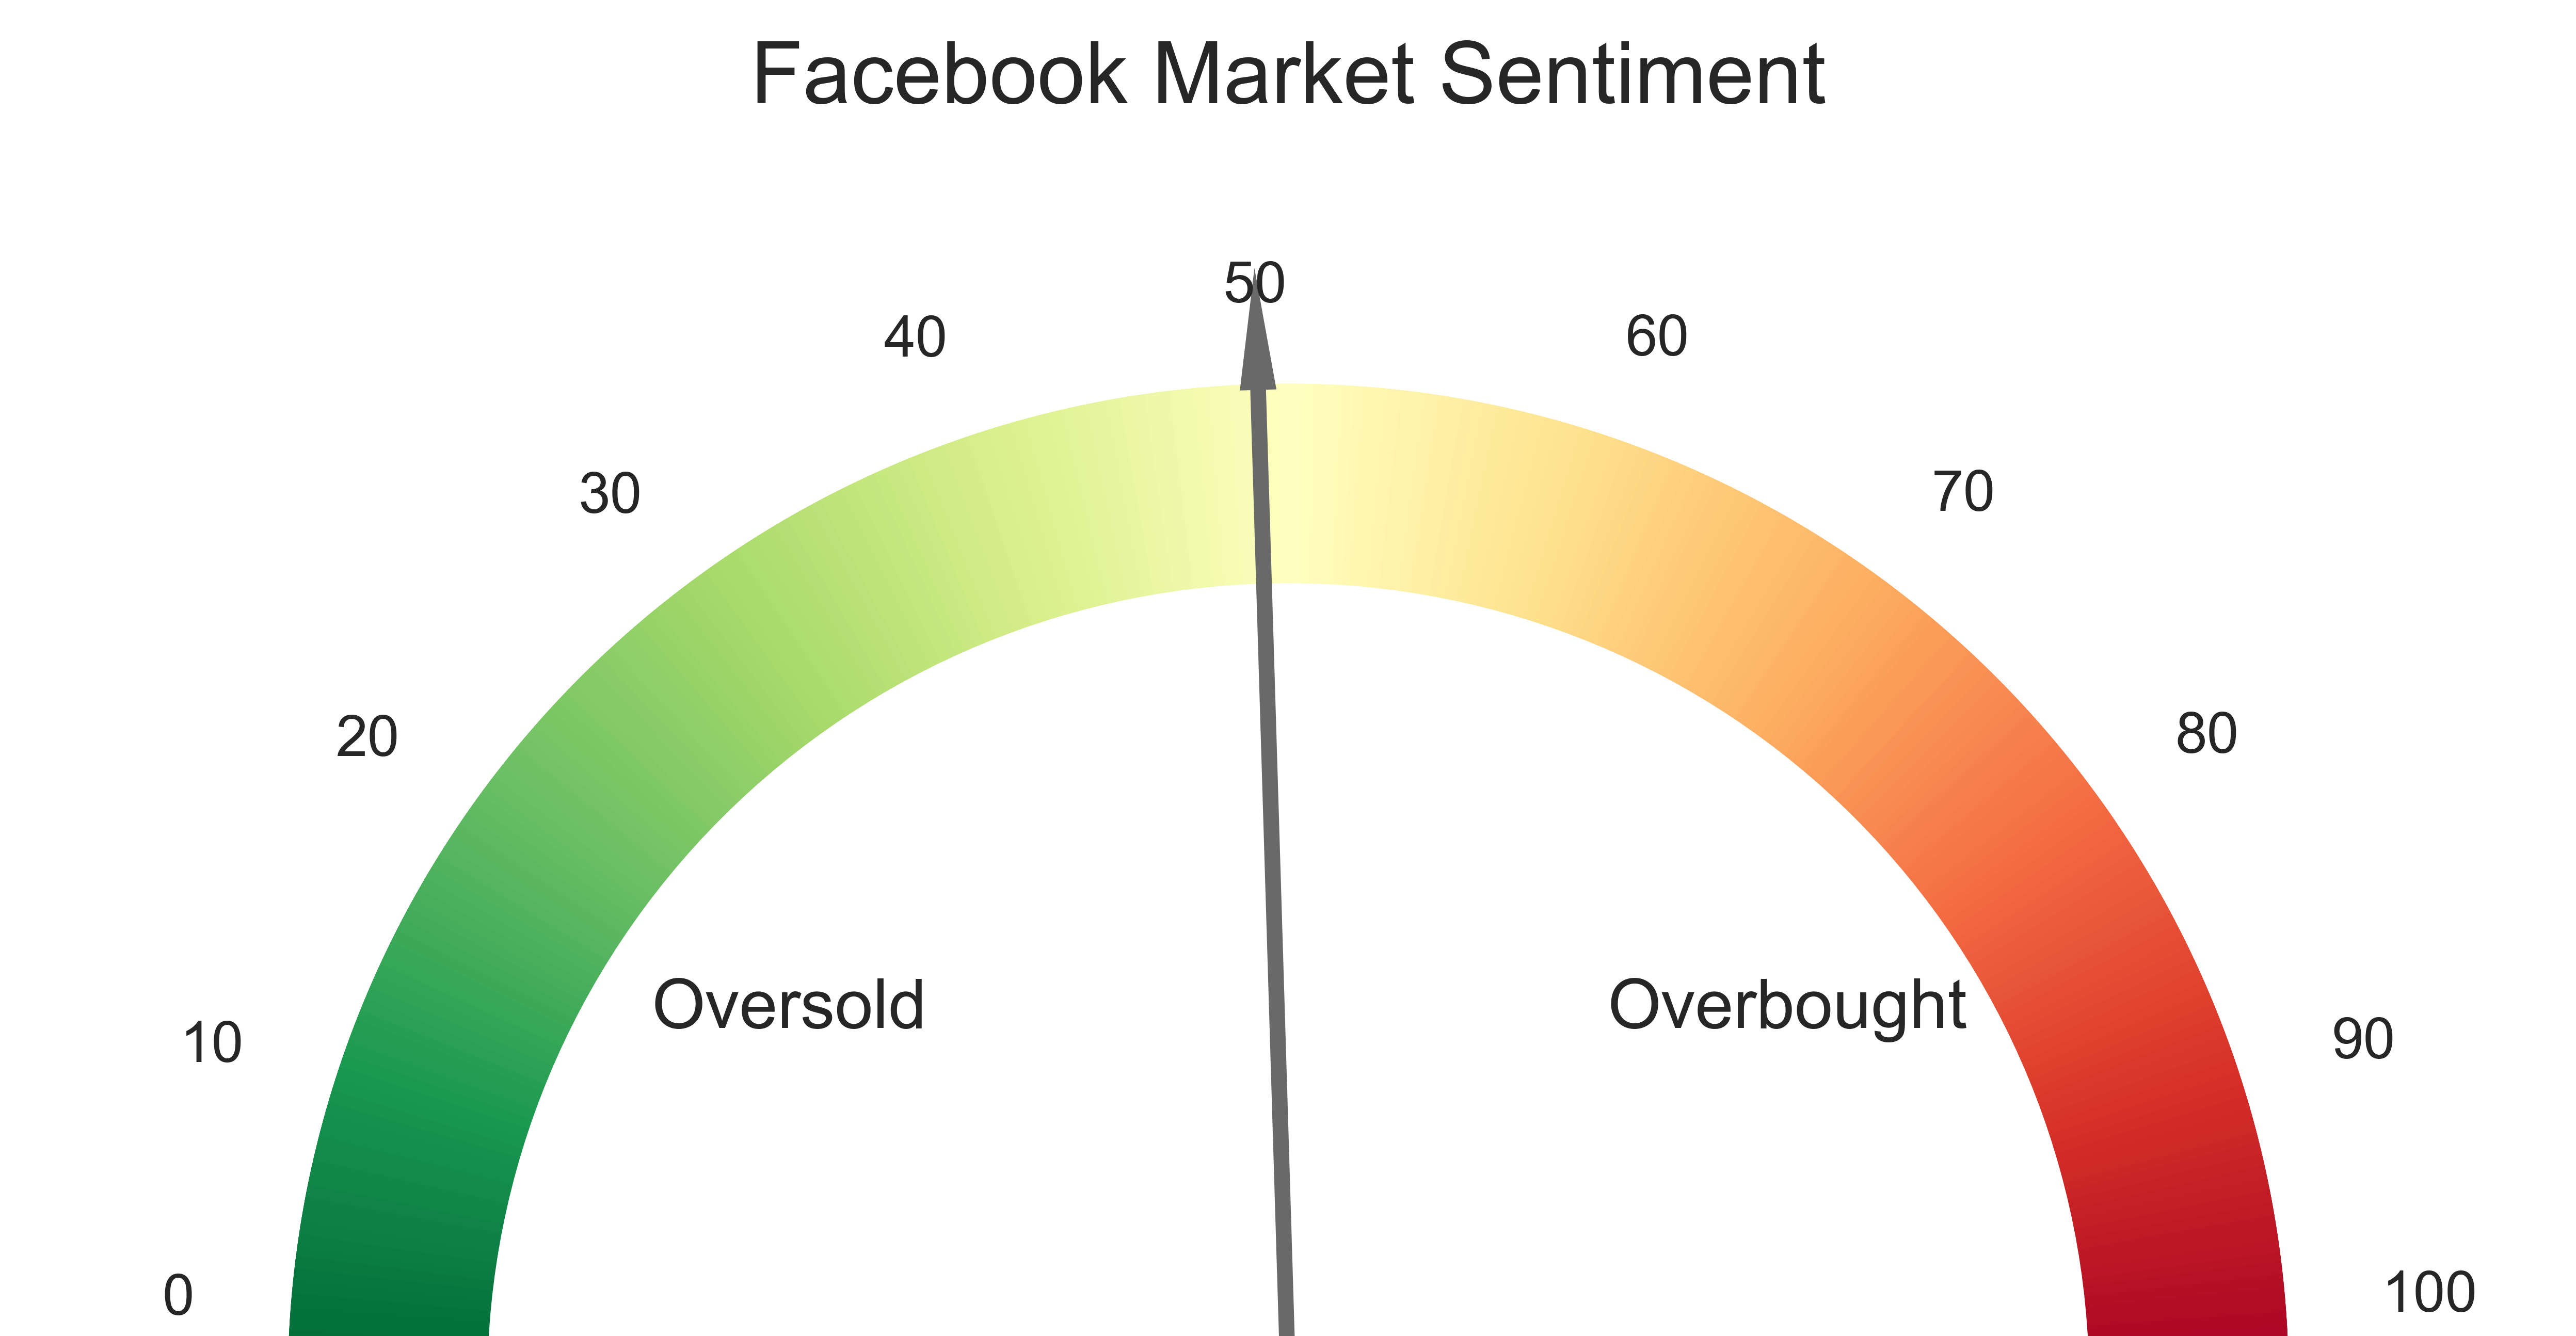

In [19]:
rsi_gauge(Facebook)

In [20]:
def google_news_fetch(name):
    """
    1. Fetch news from multiple sources from certain periods.
    2. Append df to store all news fetched from the source.
    3. Remove the irrelevant news.
    
    Input: Company name (only one word is allowed)
    
    Return: a df comprises of news related to the company from yesterday to today.
    """
    # Import dependancies 
    import pandas as pd
    import requests
    import json

    
    # create an empty df
    df = pd.DataFrame()
    
    # add source list
    source_list=["cnbc","reuters","cnn","business-insider","the-washington-post","abc-news","business-insider-uk","cbs-news","nbc-news","bbc-news","the-wall-street-journal","wired","australian-financial-review","fox-news","independent","fortune"]
    
    # add two days ago
    from datetime import date, timedelta
    day = str(date.today()-timedelta(days=2))
    
    # fetch news using newsapi 
    for idx, source in enumerate(source_list):
        url = f'https://newsapi.org/v2/everything?q={name}&qInTitle={name}&sources={source}&from={day}&sortBy=relevancy&pageSize=100&language=en&apiKey=dfc781bdbea94c6482772bfb265256a3'

        response = requests.get(url)
        
        if idx == 0:
            df = pd.DataFrame(response.json()["articles"])
        else:
            df1 = pd.DataFrame(response.json()["articles"])
            df = df.append(df1, ignore_index=True)
            
    # delete all rows that do not contain the search name
    df_final = df[(df["title"].str.contains(name, na=False)) | (df["description"].str.contains(name, na=False))]
        
        
        
        
    return df_final

In [21]:
def news_sentiment(name):
    """
    1. drop duplicated news using df.duplicated
    2. drop the remaining rows using fuzzywuzzy logic
    3. use vader to calcualate the sentiment for the news articles
    
    Input: company name (only one word is allowed)
    
    Return: a df including news of a comopany and its sentiment analysis
    """
    # Import dependancies 
    import pandas as pd

    news = google_news_fetch(name)
    # reset index
    news= news.reset_index(drop=True)
    
    # 1. drop duplicated news using df.duplicated
    news_duplicated_drop= news[news.title.duplicated()==False].reset_index(drop=True)
    
    # 2. drop the remaining rows using fuzzywuzzy logic
    from fuzzywuzzy import fuzz
    
    duplicated_articles=[]
    for i, title in enumerate(list(news_duplicated_drop.title)):
        for x in range(i):
            if fuzz.ratio(news_duplicated_drop.iloc[i].title, news_duplicated_drop.iloc[x].title) >50:
                duplicated_articles.append(i)

    news_duplicated_drop = news_duplicated_drop.drop(list(set(duplicated_articles))).reset_index(drop=True)
    
    # 3. Sentiment Analysis
        # a. Import vaderSentiment
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    
        # b. calculate the sentiment score for both the titles and descriptions of the news articles
    news_duplicated_drop = news_duplicated_drop.assign(title_sentiment=news_duplicated_drop.title.apply(lambda x: analyzer.polarity_scores(x)["compound"]))
    news_duplicated_drop = news_duplicated_drop.assign(description_sentiment=news_duplicated_drop.description.apply(lambda x: analyzer.polarity_scores(x)["compound"]))
    
    # 4. Sort by the most recent news
    import re
        # a. Convert the date to datetime format
    news_duplicated_drop.publishedAt = news_duplicated_drop.publishedAt.str.replace("T"," ")
    news_duplicated_drop.publishedAt = news_duplicated_drop.publishedAt.str.replace("Z"," ")
    news_duplicated_drop.publishedAt = pd.to_datetime(news_duplicated_drop.publishedAt,format="%Y-%m-%d %H:%M:%S")
    
        # b. Sort by the most recent date and time
    news_duplicated_drop = news_duplicated_drop.sort_values(by=["publishedAt"], ascending=False).reset_index(drop=True)
    return news_duplicated_drop


In [22]:
def news_sentiment_gauge(df):
    """
    The aim of the function is to create a graph to visualise the news sentiment of the underlying product.
    
    Input: the dataframe which consists of the mean of the aggregated news sentiment that was calculated after the news were fetched by Google News API.
    
    Return: a gauge chart of the average of the news sentiment.
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm, gridspec
    import numpy as np
    import math
    from PIL import Image
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.axes import Axes
    # set my color array and name of figure
    dial_colors = np.linspace(0,1,1000) # using linspace here as an example
    figname = 'myDial'

    # specify which index you want your arrow to point to
    arrow_index = ((df[abs(df.title_sentiment)>.1].title_sentiment.mean()+df[abs(df.description_sentiment)>.1].description_sentiment.mean())/2)*1000

    # create labels at desired locations
    # note that the pie plot plots from right to left
    labels = [' ']*len(dial_colors)*2
    labels[25] = '1'
    labels[500] = '0'
    labels[975] = '-1'

    # function plotting a colored dial
    def dial(color_array, arrow_index, labels, ax):
        # Create bins to plot (equally sized)
        size_of_groups=np.ones(len(color_array)*2)

        # Create a pieplot, half white, half colored by your color array
        white_half = np.ones(len(color_array))*.5
        color_half = color_array
        color_pallet = np.concatenate([color_half, white_half])

        cs=cm.RdYlBu(color_pallet)
        pie_wedge_collection = ax.pie(size_of_groups, colors=cs, labels=labels)

        i=0
        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor(cm.RdYlGn_r(color_pallet[i]))
            i=i+1

        # create a white circle to make the pie chart a dial
        my_circle=plt.Circle( (0,0), 0.8, color='white')
        ax.add_artist(my_circle)

        # create the arrow, pointing at specified index
        arrow_angle = ((arrow_index/float(len(color_array)))/2+.5)*3.14159
        arrow_x = 1*math.cos(arrow_angle)
        arrow_y = 1*math.sin(arrow_angle)
        ax.arrow(0,0,-arrow_x,arrow_y, width=.01, head_width=.03, head_length=.1, fc='dimgrey', ec='dimgrey') 

    # create figure and specify figure name
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(f"{company_name} News Sentiment",fontdict={"fontsize":15})

    # make dial plot and save figure
    dial(dial_colors, arrow_index, labels, ax)
    ax.set_aspect('equal')

    # add textbox "Oversold" and "Overbought"
    plt.text(0.3, 0.65, 'Negative', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=12)
    plt.text(0.5, 0.75, 'Neutral', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=12)
    plt.text(0.7, 0.65, 'Positive', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=12)

    plt.savefig(figname + '.png',dpi=800, bbox_inches='tight')
    plt.close()

    # open figure and crop bottom half
    im = Image.open(figname + '.png',mode="r")
    width, height = im.size

    # crop bottom half of figure
    # function takes top corner &lt;span                data-mce-type="bookmark"                id="mce_SELREST_start"              data-mce-style="overflow:hidden;line-height:0"              style="overflow:hidden;line-height:0"           &gt;&amp;#65279;&lt;/span&gt;and bottom corner coordinates
    # of image to keep, (0,0) in python images is the top left corner
    im_cropped = im.crop((0, 0, width, int(height/2.0))).save('news_sentiment.png')
    
    return Image.open('news_sentiment.png')


In [92]:
Facebook_news= news_sentiment("Tesla")

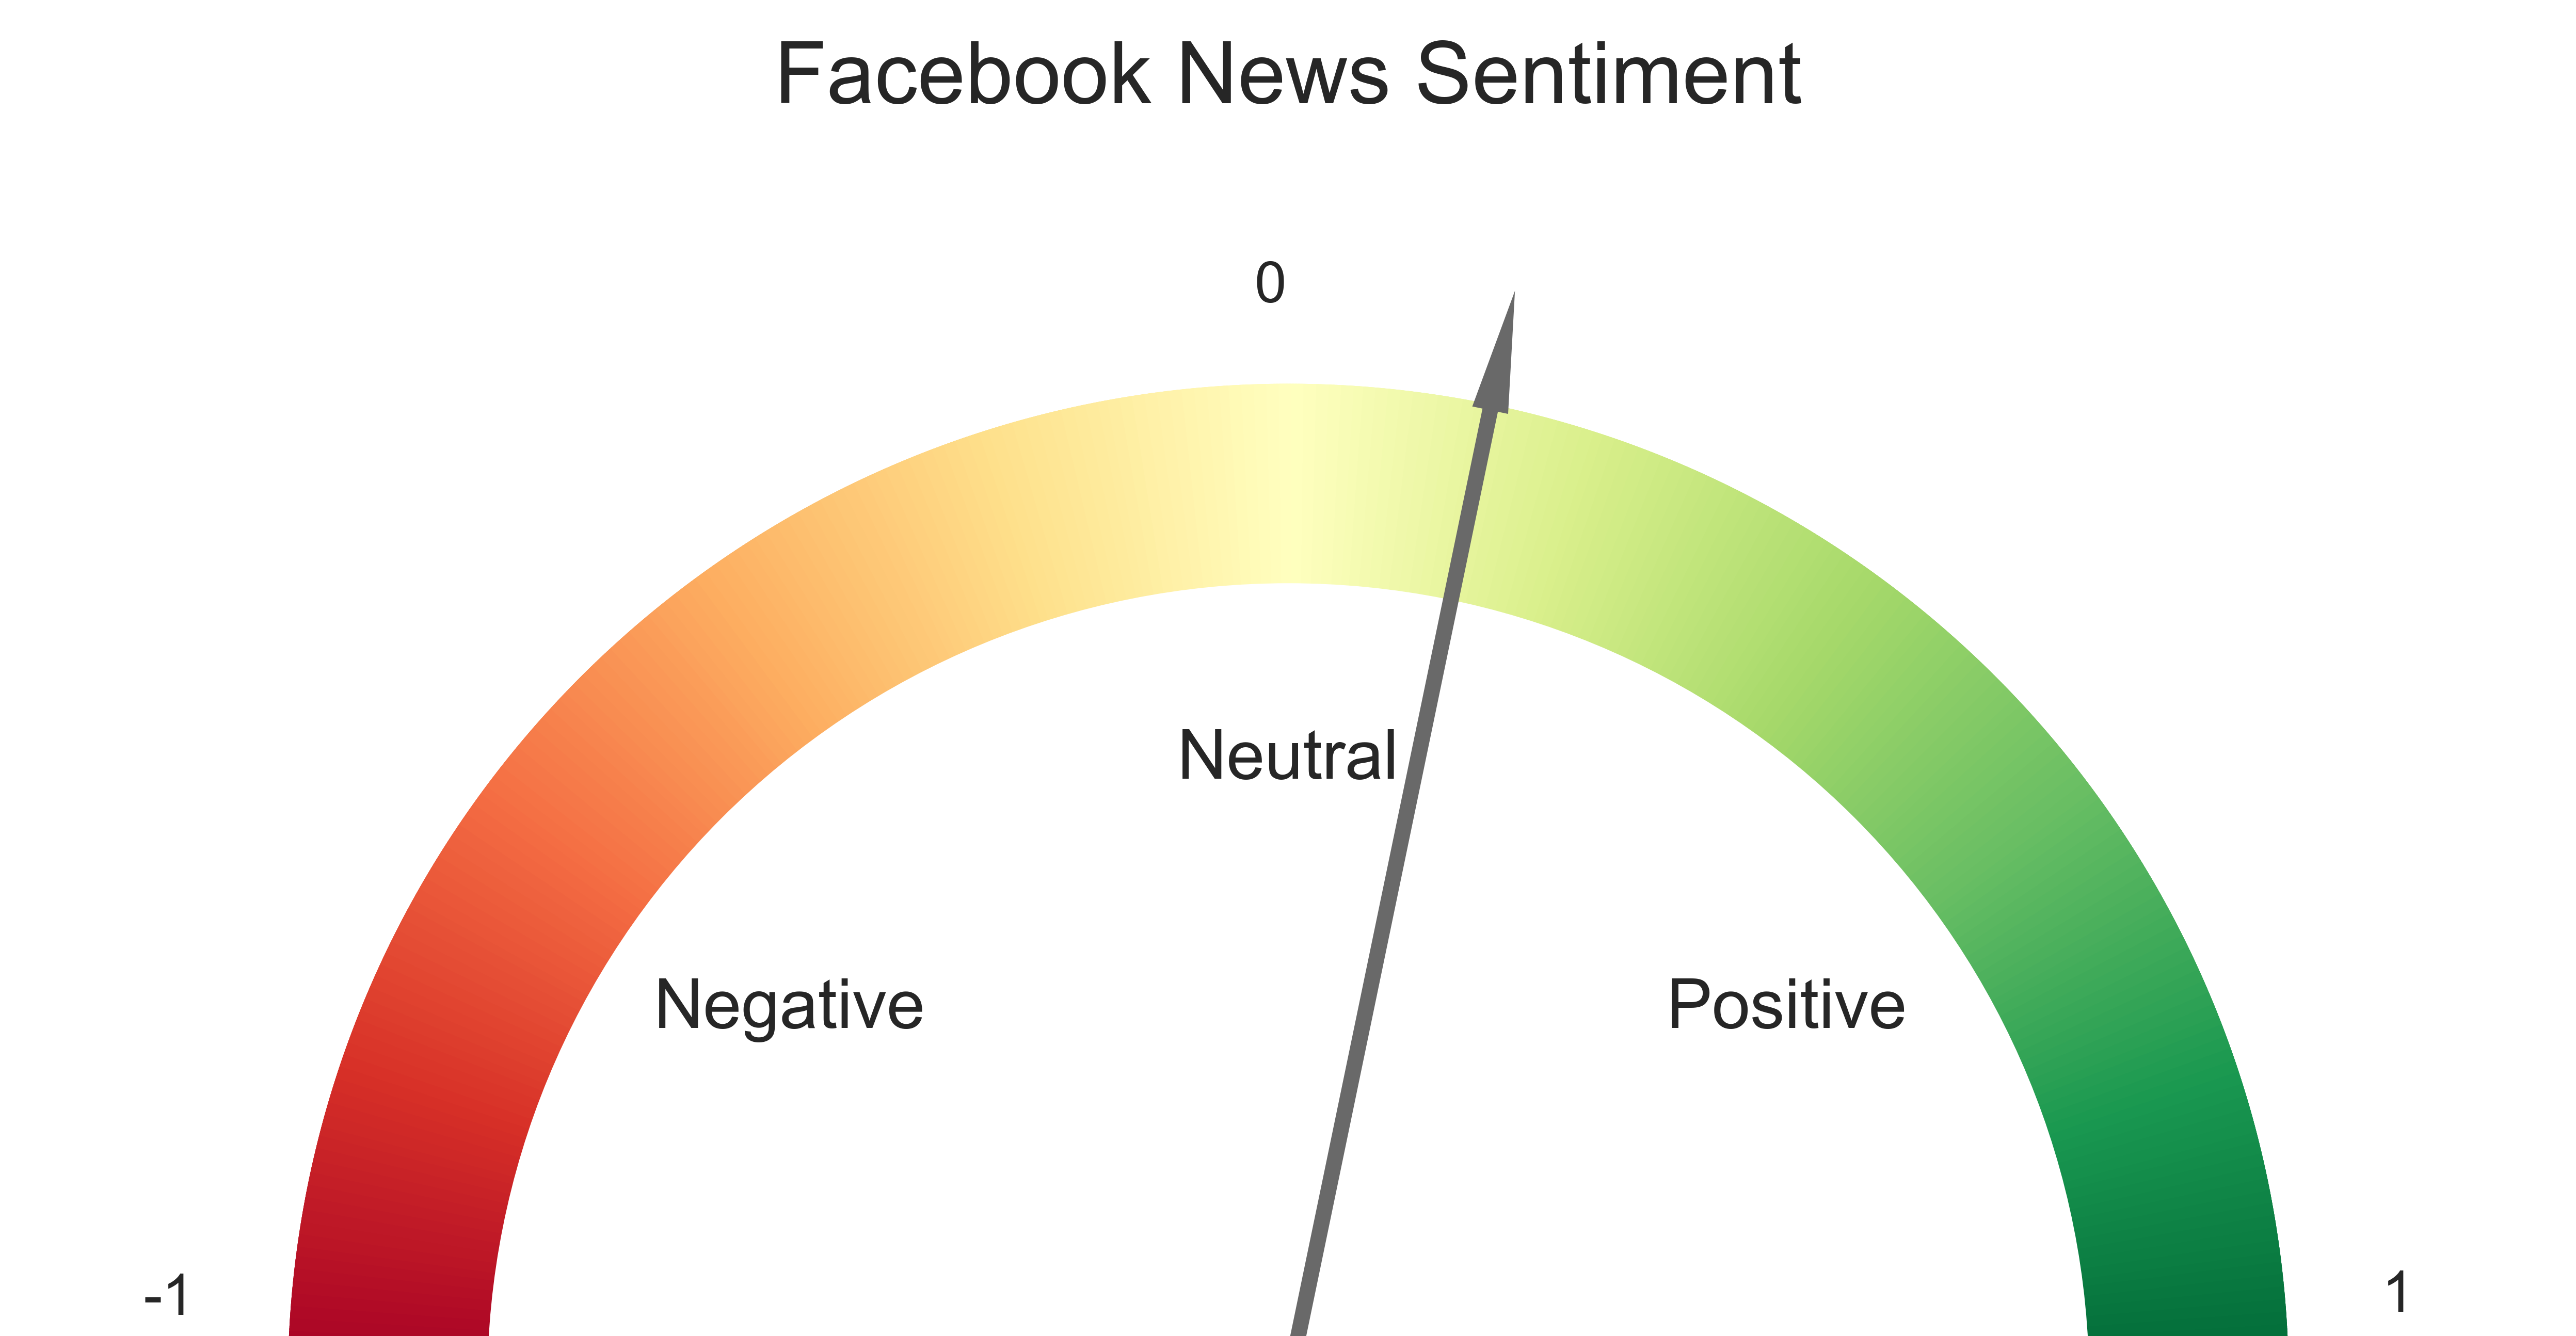

In [93]:
news_sentiment_gauge(Facebook_news)

In [94]:
Facebook_news

,source,author,title,description,url,urlToImage,publishedAt,content,title_sentiment,description_sentiment
0,"{'id': 'reuters', 'name': 'Reuters'}",Reuters Editorial,Exclusive: U.S. agency probes 12th Tesla crash...,The U.S. auto safety agency said Friday it wil...,https://www.reuters.com/article/us-tesla-crash...,https://s3.reutersmedia.net/resources/r/?m=02&...,2019-12-13 20:20:55,WASHINGTON (Reuters) - The U.S. auto safety ag...,-0.2960,0.2732
1,"{'id': 'business-insider', 'name': 'Business I...",Graham Rapier,"Shifting Gears: A massive trucking bankruptcy,...",Happy Friday and welcome to Shifting Gears. In...,https://www.businessinsider.com/shifting-gears...,https://image.businessinsider.com/5df3b198fd9d...,2019-12-13 16:11:24,None,0.5719,0.9168
2,"{'id': 'fox-news', 'name': 'Fox News'}",Gary Gastelu,The Tesla Cybertruck will be a medium duty tru...,Bigger than it looks.,https://www.foxnews.com/auto/tesla-cybertruck-...,https://static.foxnews.com/foxnews.com/content...,2019-12-13 15:01:43,The Tesla Cybertruck may be even bigger than i...,0.0000,0.0000
3,"{'id': 'cnbc', 'name': 'CNBC'}",Annie Palmer,Tesla loses its third general counsel in the l...,Tesla's general counsel Jonathan Chang is exit...,https://www.cnbc.com/2019/12/12/tesla-loses-it...,https://image.cnbcfm.com/api/v1/image/10596899...,2019-12-12 17:22:00,Tesla's general counsel is leaving the company...,-0.3182,0.0000
4,"{'id': 'reuters', 'name': 'Reuters'}",Reuters Editorial,Thyssenkrupp in talks with Tesla about German ...,Thyssenkrupp is hoping to win contracts for a ...,https://www.reuters.com/article/us-thyssenkrup...,https://s1.reutersmedia.net/resources/r/?m=02&...,2019-12-12 17:13:44,FRANKFURT (Reuters) - Thyssenkrupp is hoping t...,0.0000,0.7650
5,"{'id': 'independent', 'name': 'Independent'}","Anthony Cuthbertson, Anthony Cuthbertson",Tesla wants to replace windscreen wipers with ...,'Pulsed laser cleaning system' could soon find...,https://www.independent.co.uk/life-style/gadge...,https://static.independent.co.uk/s3fs-public/t...,2019-12-12 17:13:41,Tesla has filed a patent for high-tech windscr...,0.0000,0.0000
6,"{'id': 'business-insider', 'name': 'Business I...",Mark Matousek,The Porsche Taycan Turbo's range is much lower...,The Porsche Taycan Turbo electric sports car h...,https://www.businessinsider.com/porsche-taycan...,https://image.businessinsider.com/5df2597dfd9d...,2019-12-12 16:47:20,The Porsche Taycan Turbo electric sports car h...,-0.2960,0.0000
7,"{'id': 'business-insider', 'name': 'Business I...",Mark Matousek,Inside Tesla's overhaul plan for its sales and...,Tesla has begun the process of merging the rol...,https://www.businessinsider.com/tesla-announce...,https://image.businessinsider.com/5df18905fd9d...,2019-12-12 14:56:46,Tesla has begun the process of merging the rol...,0.2023,0.0000
8,"{'id': 'cnbc', 'name': 'CNBC'}",Tyler Clifford,Everything Jim Cramer said about the stock mar...,"""Mad Money"" host Jim Cramer breaks down why Te...",https://www.cnbc.com/2019/12/11/jim-cramers-ma...,https://image.cnbcfm.com/api/v1/image/10443317...,2019-12-12 00:49:24,CNBC's Jim Cramer reveals why he is now a beli...,-0.4939,-0.4939


In [25]:
Facebook_news.iloc[:,2:5].drop(columns=["description"]).assign(publisher=Facebook_news.source.apply(lambda x: x['id']))

,title,url,publisher
0,Facebook drops 4% on report the FTC might bloc...,https://www.businessinsider.com/facebook-stock...,business-insider
1,FTC weighs seeking injunction against Facebook...,https://www.reuters.com/article/us-facebook-ft...,reuters
2,Facebook falls on report FTC weighing injuncti...,https://www.cnbc.com/2019/12/12/facebook-falls...,cnbc
3,Italian judge orders Facebook to reopen neo-fa...,https://www.reuters.com/article/italy-facebook...,reuters
4,Stories now account for nearly 10% of all Face...,https://www.businessinsider.com/instagram-stor...,business-insider
5,The CEO of Cisco explains how its new plan to ...,https://www.businessinsider.com/cisco-ceo-chuc...,business-insider
6,Facebook taps data to predict likely 2020 tren...,https://www.cnn.com/2019/12/12/tech/facebook-2...,cnn
7,Facebook delays naming oversight board members...,https://www.cnbc.com/2019/12/12/facebook-delay...,cnbc
8,Facebook Pledges $130M to Fund “Supreme Court”...,https://www.wsj.com/articles/facebook-pledges-...,the-wall-street-journal
9,Facebook has made AR ads available to all mark...,https://www.businessinsider.com/facebook-exper...,business-insider


In [86]:
def fiftytwo_week_range_gauge(df):
    """
    The aim of the function is to create a graph to visualise the price range within a year of the underlying product.
    
    Input: dataframe with the following input format:
    "date": time series of the stock price in datetime format
    "adjusted close": the adjusted close price in numpy/float format
    
    Return: A gauge graph displaying the highest and lowest price for the past 365 days as well as the current price.
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm, gridspec
    import numpy as np
    import pandas as pd
    import math
    from PIL import Image
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.axes import Axes
    # set your color array and name of figure here:
    dial_colors = np.linspace(0,1,1000) # using linspace here as an example
    figname = 'myDial'
    # find the day one year ago
    from datetime import datetime, timedelta, date
    date_last_year = date.today() - timedelta(days=365)
    
    # calculate the price
    current_price= df.iloc[-1]["adjusted close"]
    max_price= df.iloc[int(df.loc[df.date==pd.to_datetime(str(pd.to_datetime(date_last_year).date()))].index.values):]["adjusted close"].max()
    min_price= df.iloc[int(df.loc[df.date==pd.to_datetime(str(pd.to_datetime(date_last_year).date()))].index.values):]["adjusted close"].min()
    
    # specify which index you want your arrow to point to
    arrow_index = float((current_price-min_price)/(max_price-min_price))*1000
    


    # create labels at desired locations
    # note that the pie plot plots from right to left
    labels = [' ']*len(dial_colors)*2
    labels[1] = max_price
    labels[999] = min_price

    # function plotting a colored dial
    def dial(color_array, arrow_index, labels, ax):
        # Create bins to plot (equally sized)
        size_of_groups=np.ones(len(color_array)*2)

        # Create a pieplot, half white, half colored by your color array
        white_half = np.ones(len(color_array))*.5
        color_half = color_array
        color_pallet = np.concatenate([color_half, white_half])

        cs=cm.RdYlBu(color_pallet)
        pie_wedge_collection = ax.pie(size_of_groups, colors=cs, labels=labels)

        i=0
        for pie_wedge in pie_wedge_collection[0]:
            pie_wedge.set_edgecolor(cm.RdYlGn(color_pallet[i])) #RdYlGn_r is the reverse of the RdYlGn pallet color 
            i=i+1

        # create a white circle to make the pie chart a dial
        my_circle=plt.Circle( (0,0), 0.8, color='white')
        ax.add_artist(my_circle)

        # create the arrow, pointing at specified index
        arrow_angle = (arrow_index/float(len(color_array)))*3.14159
        arrow_x = 1*math.cos(arrow_angle)
        arrow_y = 1*math.sin(arrow_angle)
        ax.arrow(0,0,-arrow_x,arrow_y, width=.01, head_width=.03, head_length=.1, fc='dimgrey', ec='dimgrey') 

    # create figure and specify figure name
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(f"{company_name} 52-Week Range",fontdict={"fontsize":15})

    # make dial plot and save figure
    dial(dial_colors, arrow_index, labels, ax)
    ax.set_aspect('equal')   

    plt.savefig(figname + '.png', dpi=800,bbox_inches='tight')
    plt.close()

    # open figure and crop bottom half
    im = Image.open(figname + '.png',mode="r")
    width, height = im.size

    # crop bottom half of figure
    # function takes top corner &lt;span                data-mce-type="bookmark"                id="mce_SELREST_start"              data-mce-style="overflow:hidden;line-height:0"              style="overflow:hidden;line-height:0"           &gt;&amp;#65279;&lt;/span&gt;and bottom corner coordinates
    # of image to keep, (0,0) in python images is the top left corner
    im_cropped = im.crop((0, 0, width, int(height/1.9))).save('52_week_range.png')
    
    return Image.open('52_week_range.png')


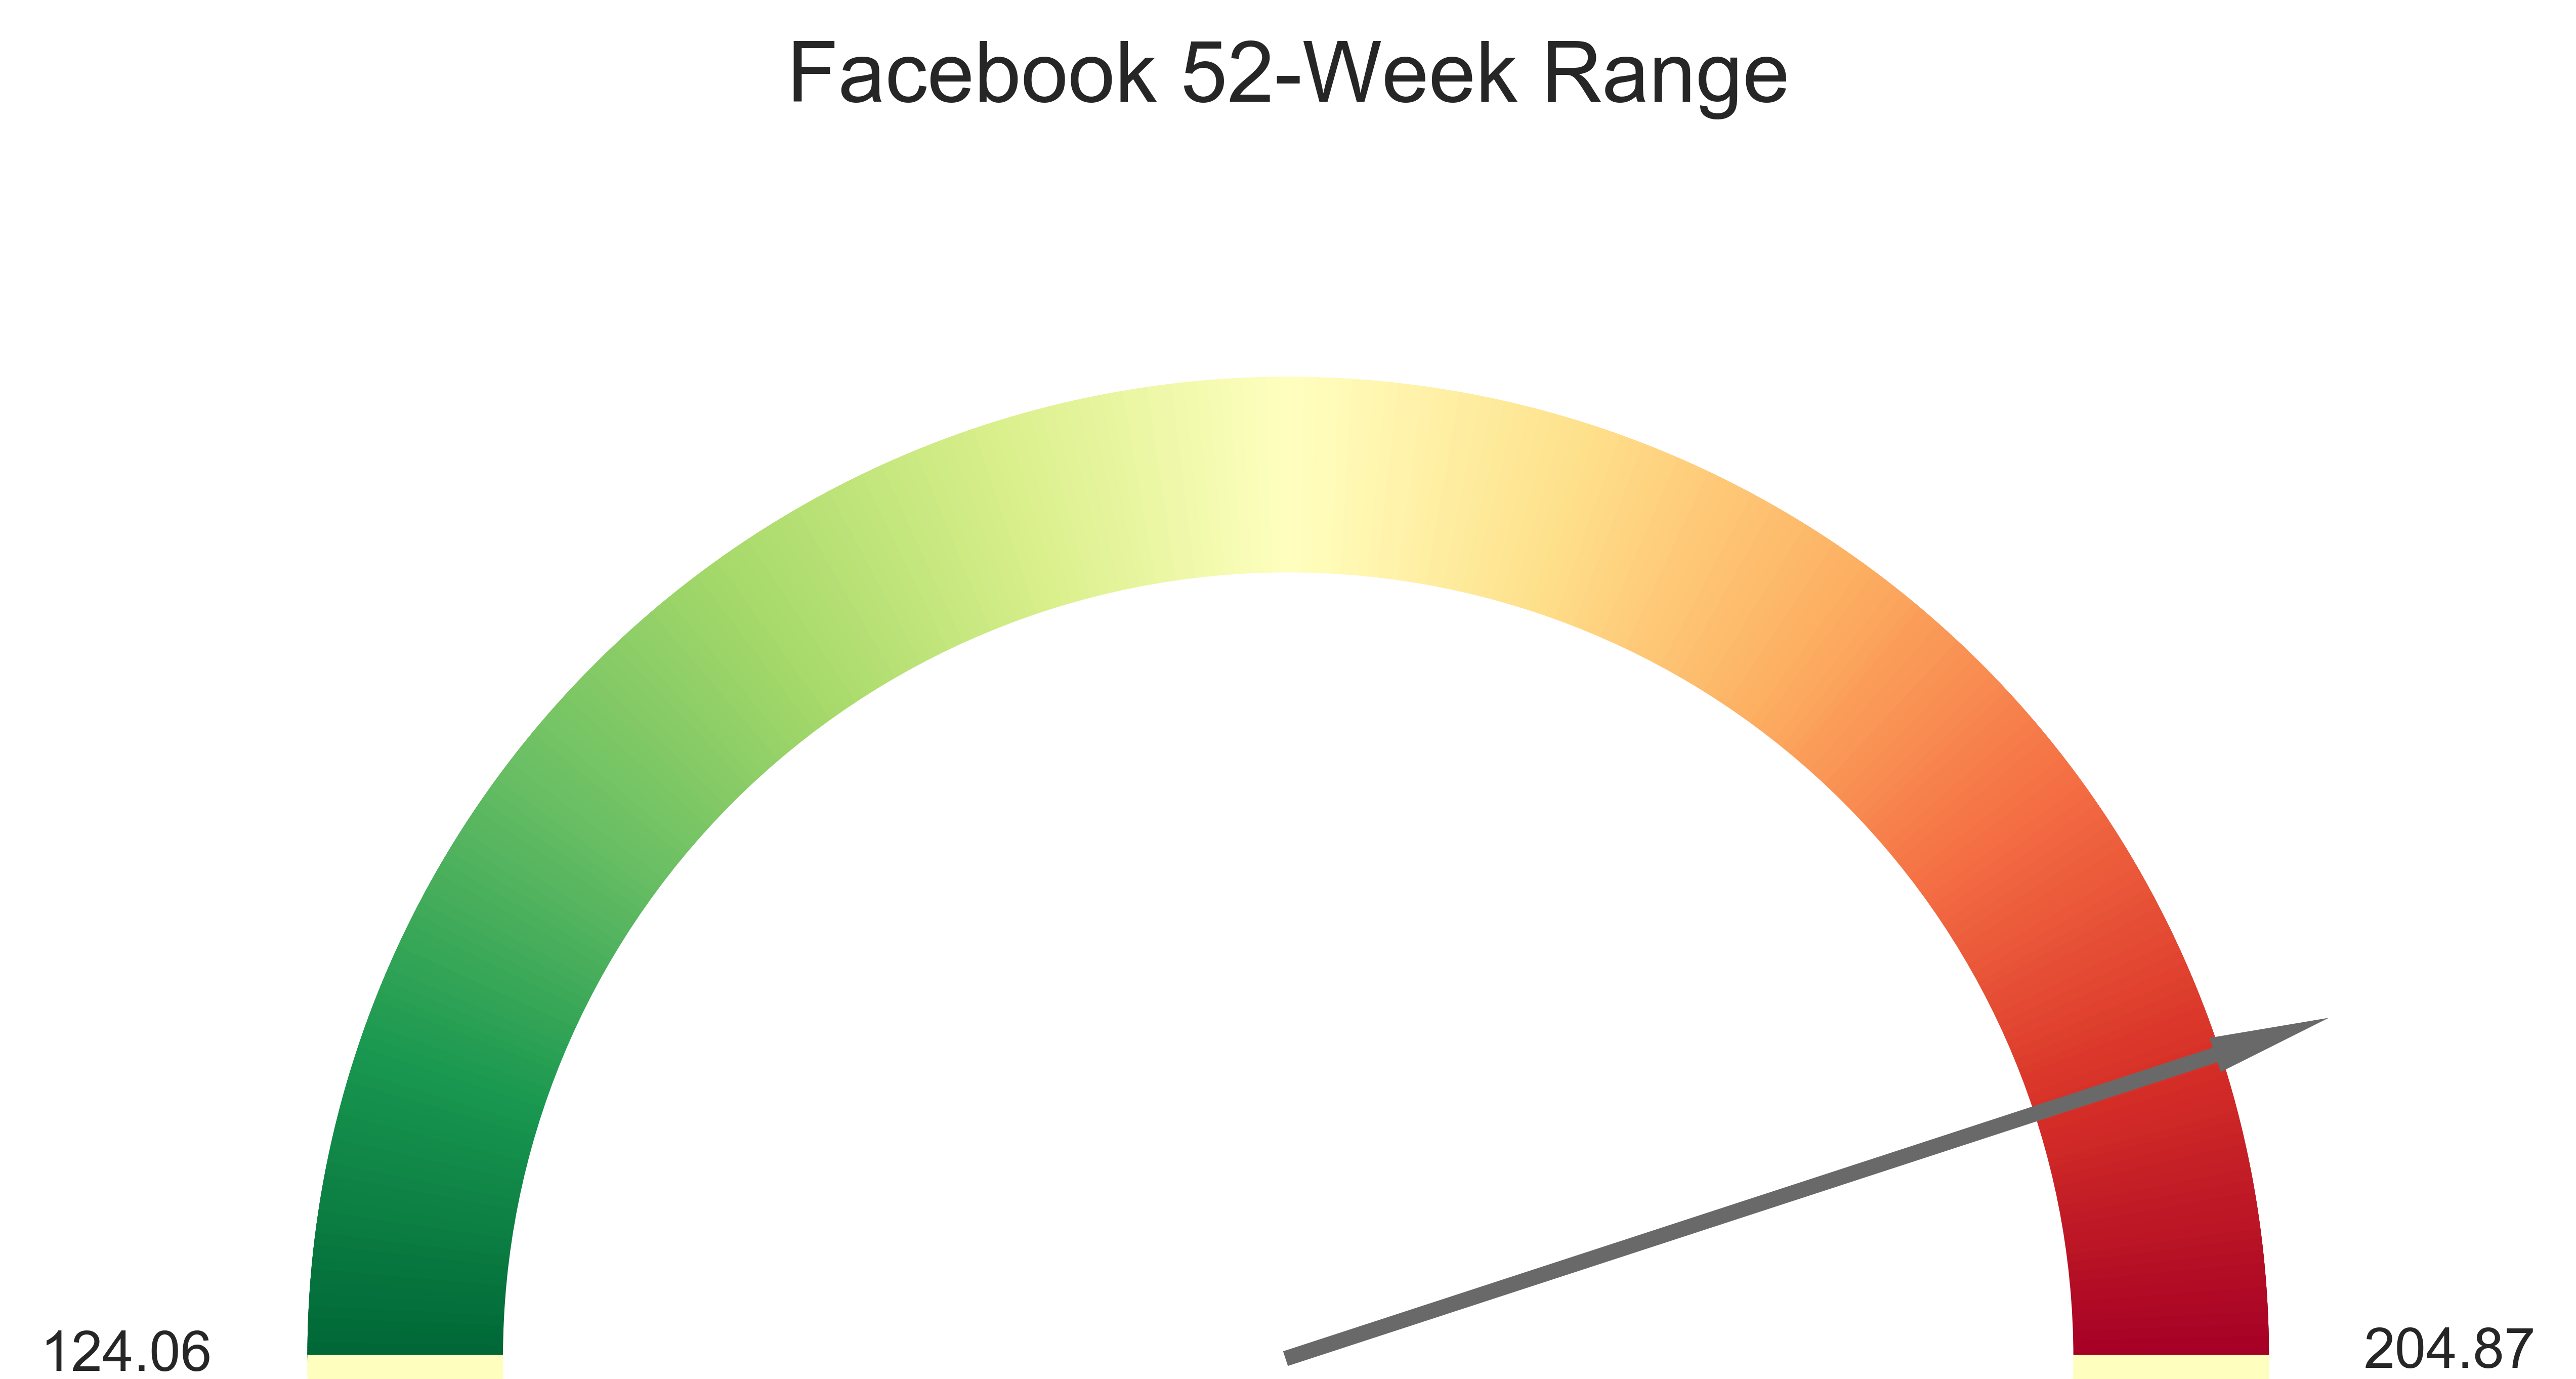

In [87]:
fiftytwo_week_range_gauge(Facebook)

## 4. Machine Learning 

One of the most common discussed topics in finance is whether it is possible to predict the price movement of the underlying stock.

In this session, two machine learning tools (Random Forest & LSTM (Long Short Term Memory)) are used to forecast the price movement of the stocks.

### Data cleaning

Delete all rows with NaN values

In [29]:
# check NaN values
Facebook.isnull().sum()

date               0
open               0
high               0
low                0
close              0
adjusted close     0
volume             0
open/close         0
SMA_10             9
SMA_20            19
SMA_50            49
bb_bbm             0
bb_bbh             0
bb_bbl             0
ATR                0
RSI                1
stoch              0
stoch_signal       0
MACD              25
MACD_signal       33
MACD_diff         33
ichimoku_a         0
ichimoku_b         0
EMA_10             9
EMA_20            19
EMA_50            49
dtype: int64

In [30]:
# Drop NaN values which is not present in EMA_50. From the above functions, all NaN values are located at the head of the df. Hence, dropping NaN values from the column which has the highest number of NaN would work. 
Facebook = Facebook[~Facebook.EMA_50.isnull()].reset_index(drop=True)

In [31]:
# check NaN values again
Facebook.isnull().sum()

date              0
open              0
high              0
low               0
close             0
adjusted close    0
volume            0
open/close        0
SMA_10            0
SMA_20            0
SMA_50            0
bb_bbm            0
bb_bbh            0
bb_bbl            0
ATR               0
RSI               0
stoch             0
stoch_signal      0
MACD              0
MACD_signal       0
MACD_diff         0
ichimoku_a        0
ichimoku_b        0
EMA_10            0
EMA_20            0
EMA_50            0
dtype: int64

### Assign validation set

In [32]:
# the stock price in 2019 is used as the validation set

Facebook_validation_set = Facebook.iloc[int(Facebook.loc[Facebook.date==pd.to_datetime("2019-01-02")].index.values):]

# drop "close" column
Facebook_validation_set = Facebook_validation_set.drop(columns=["close"])

In [33]:
Facebook_validation_set

,date,open,high,low,adjusted close,volume,open/close,SMA_10,SMA_20,SMA_50,bb_bbm,bb_bbh,bb_bbl,ATR,RSI,stoch,stoch_signal,MACD,MACD_signal,MACD_diff,ichimoku_a,ichimoku_b,EMA_10,EMA_20,EMA_50
1616,2019-01-02,128.990,137.5100,128.5600,135.68,28146193.0,0.950693,132.798,137.0870,141.2354,137.0870,148.949599,125.224401,6.057658,48.126689,52.378982,42.628603,2.702906,2.689030,0.013875,134.535000,141.75500,133.930484,135.871904,142.157208
1617,2019-01-03,134.690,137.1700,131.1200,131.74,22717948.0,1.022393,131.606,136.6195,140.7892,136.6195,148.550984,124.688016,6.057111,43.935468,37.929535,41.232338,2.709032,2.693031,0.016001,132.685000,140.84000,133.532215,135.478389,141.748690
1618,2019-01-04,134.010,138.0000,133.7500,137.95,29002059.0,0.971439,132.077,136.6205,140.4526,136.6205,148.552426,124.688574,6.071603,51.155662,64.941279,51.749932,2.187575,2.591939,-0.404365,132.807500,140.18500,134.335448,135.713780,141.599722
1619,2019-01-07,137.560,138.8700,135.9100,138.05,20089337.0,0.996451,132.542,136.5415,140.1258,136.5415,148.413449,124.669551,5.849346,51.264504,65.604540,56.158451,1.746119,2.422775,-0.676657,133.025000,140.18000,135.010821,135.936278,141.460517
1620,2019-01-08,139.890,143.1400,139.5400,142.53,26263793.0,0.981478,134.300,136.7970,140.0556,136.7970,148.950194,124.643806,5.795107,55.995423,85.159319,71.901712,1.022971,2.142814,-1.119843,134.810000,139.71000,136.377945,136.564251,141.502458
1621,2019-01-09,142.950,144.7000,141.2700,144.23,22205879.0,0.991125,136.317,136.9160,139.9212,136.9160,149.309015,124.522985,5.626171,57.674452,96.893559,82.552472,0.309132,1.776078,-1.466946,135.867500,139.71000,137.805591,137.294322,141.609420
1622,2019-01-10,143.080,144.5600,140.8400,144.20,16125004.0,0.992233,137.319,137.0220,139.8978,137.0220,149.624374,124.419626,5.490015,57.632661,97.693727,93.248868,-0.251273,1.370608,-1.621881,135.867500,139.71000,138.968211,137.952006,141.711012
1623,2019-01-11,143.150,145.3600,142.5700,143.80,12908031.0,0.995480,138.247,136.9870,139.9320,136.9870,149.509743,124.464257,5.297157,57.039190,93.017010,95.868098,-0.655565,0.965373,-1.620938,136.032500,139.71000,139.846718,138.508958,141.792933
1624,2019-01-14,142.000,146.5700,141.2700,145.39,20520278.0,0.976683,139.466,137.0060,139.9154,137.0060,149.578431,124.433569,5.297360,58.852995,94.989384,95.233374,-1.091684,0.553962,-1.645646,136.335000,139.71000,140.854587,139.164295,141.933994
1625,2019-01-15,146.010,150.6800,145.9900,148.95,24068822.0,0.980262,141.252,137.2505,139.8586,137.2505,150.532327,123.968673,5.296835,62.654806,93.021380,93.675925,-1.704921,0.102185,-1.807106,138.875000,139.71000,142.326481,140.096267,142.209132


In [34]:
# save the remaining as the testing set 

Facebook_test = Facebook.iloc[:1616]

In [35]:
# drop "close" column
Facebook_test = Facebook_test.drop(columns=["close"])

In [36]:
Facebook_test

,date,open,high,low,adjusted close,volume,open/close,SMA_10,SMA_20,SMA_50,bb_bbm,bb_bbh,bb_bbl,ATR,RSI,stoch,stoch_signal,MACD,MACD_signal,MACD_diff,ichimoku_a,ichimoku_b,EMA_10,EMA_20,EMA_50
0,2012-07-30,23.995,24.04,23.03,23.15,29285900.0,1.036501,27.520,29.23780,29.838636,29.23780,34.044388,24.431212,1.573043,23.935951,9.375000,8.405169,1.525536,0.890440,0.635096,26.8775,33.640,27.046144,28.449746,30.538853
1,2012-07-31,23.370,23.37,21.61,21.71,56179400.0,1.076462,26.882,28.78475,29.508200,28.78475,34.541979,23.027521,1.586397,21.228230,1.021450,8.122346,1.869091,1.086170,0.782920,26.5400,33.305,26.075936,27.807865,30.192623
2,2012-08-01,21.500,21.58,20.84,20.88,44604400.0,1.029693,26.059,28.26875,29.245200,28.26875,34.857452,21.680048,1.535226,19.835410,0.391007,3.595819,2.183168,1.305570,0.877598,26.1525,32.920,25.131220,27.148068,29.827422
3,2012-08-02,20.770,20.84,19.82,20.04,56374500.0,1.036427,25.163,27.69725,29.026000,27.69725,35.018275,20.376225,1.501281,18.511642,2.059925,1.157461,2.471369,1.538729,0.932639,25.5075,28.240,24.205544,26.471110,29.443602
4,2012-08-03,20.360,22.16,19.90,21.09,80647000.0,0.965386,24.396,27.16525,28.807800,27.16525,34.777335,19.553165,1.555475,25.229001,13.119835,5.190256,2.585243,1.748032,0.837211,25.5025,26.705,23.639081,25.958623,29.116010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,2018-12-24,123.100,129.74,123.02,124.06,22066002.0,0.992262,137.515,138.02500,143.469600,138.02500,149.319497,126.730503,5.842351,31.108947,4.302855,10.172827,3.487921,2.101514,1.386407,135.1050,141.755,134.242313,137.260643,144.022888
1612,2018-12-26,126.000,134.24,125.89,134.18,39723370.0,0.939037,136.725,137.91500,143.078400,137.91500,149.313810,126.516190,6.152183,45.302172,46.172942,18.970827,3.302085,2.341628,0.960457,134.8100,141.755,134.230983,136.967248,143.636892
1613,2018-12-27,132.440,134.99,129.67,134.52,31202509.0,0.984538,135.727,137.89100,142.698400,137.89100,149.316249,126.465751,6.092742,45.706884,47.579644,32.685147,3.091734,2.491649,0.600085,134.8100,141.755,134.283532,136.734177,143.279367
1614,2018-12-28,135.340,135.92,132.20,133.20,22627569.0,1.016066,134.546,137.71300,142.186800,137.71300,149.312778,126.113222,5.923260,44.335352,42.118329,45.290305,2.996995,2.592718,0.404277,134.7900,141.755,134.086526,136.397589,142.884098


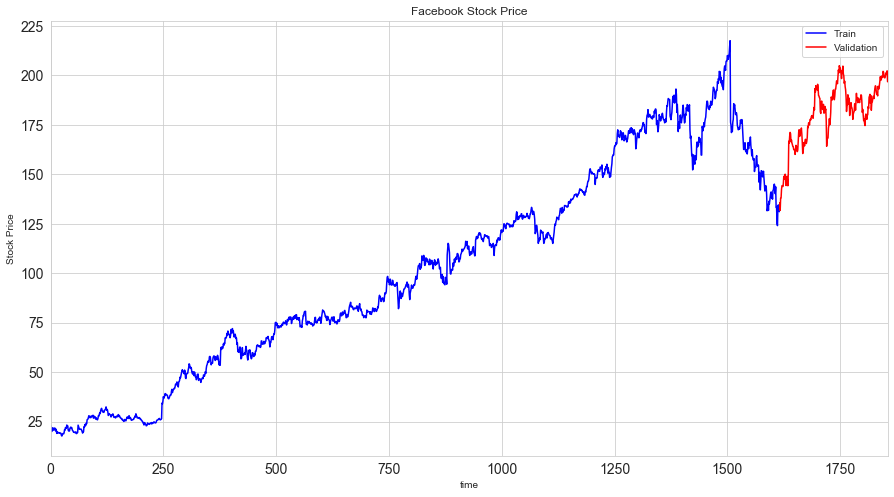

In [37]:
# Visualise the stock price chart with the distinguishment of training set and validation set using normal plotting

Facebook_test["adjusted close"].plot(figsize = (15,8), title = 'Facebook Stock Price', fontsize = 14, label = 'Train', color="blue")
Facebook_validation_set["adjusted close"].plot(figsize = (15,8), title = 'Facebook Stock Price', fontsize =14, label = 'Validation', color="red")
plt.xlabel('time')
plt.ylabel('Stock Price')
plt.legend(loc = 'best');

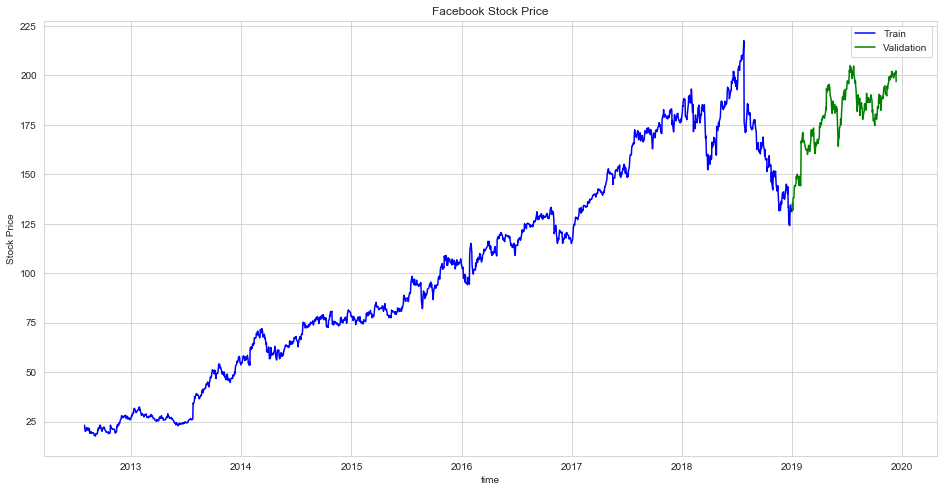

In [38]:
# Visualise the stock price chart with the distinguishment of training set and validation set using subplots

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(Facebook_test["date"],Facebook_test["adjusted close"], label = 'Train', color="blue")
ax.plot(Facebook_validation_set["date"],Facebook_validation_set["adjusted close"], label = 'Validation', color="green")
ax.set_title("Facebook Stock Price")
ax.set_xlabel('time')
ax.set_ylabel('Stock Price')
ax.legend(loc = 'best');

### 4.1 Machine learning (basics)

#### NOTE: 
_from sklearn.model_selection import train_test_split_ method can't be used!

In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model.

__These methods cannot be directly used with time series data__

This is because they assume that there is no relationship between the observations, that each observation is independent.

This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed.

In time series forecasting, this evaluation of models on historical data is called __backtesting__. In some time series domains, such as meteorology, this is called hindcasting, as opposed to forecasting.

In [39]:
# Use sklearn to split my data

from sklearn.model_selection import TimeSeriesSplit

In [40]:
# import all relevant sklearn machine learning models

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import random

# import measurement to measure the score of the models
from sklearn.metrics import r2_score, mean_squared_error

### Data Preparation

1. Create target and features columns
2. Shift the data for one day  

In [95]:
# Create target (price) and features columns for the ease of further analysis
target = ["adjusted close"]
col_to_remove = ["date","open"]
features = [col for col in Facebook_test.columns if col not in target+col_to_remove]

In [42]:
features

['high',
 'low',
 'volume',
 'open/close',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'bb_bbm',
 'bb_bbh',
 'bb_bbl',
 'ATR',
 'RSI',
 'stoch',
 'stoch_signal',
 'MACD',
 'MACD_signal',
 'MACD_diff',
 'ichimoku_a',
 'ichimoku_b',
 'EMA_10',
 'EMA_20',
 'EMA_50']

In [43]:
# shift the features for one day in order to make stock price predictions based on the information we receive on the day before

y_train= Facebook_test["adjusted close"][1:]
X_train= Facebook_test[features].shift(1).dropna()

In [44]:
X_train

,high,low,volume,open/close,SMA_10,SMA_20,SMA_50,bb_bbm,bb_bbh,bb_bbl,ATR,RSI,stoch,stoch_signal,MACD,MACD_signal,MACD_diff,ichimoku_a,ichimoku_b,EMA_10,EMA_20,EMA_50
1,24.04,23.03,29285900.0,1.036501,27.520,29.23780,29.838636,29.23780,34.044388,24.431212,1.573043,23.935951,9.375000,8.405169,1.525536,0.890440,0.635096,26.8775,33.640,27.046144,28.449746,30.538853
2,23.37,21.61,56179400.0,1.076462,26.882,28.78475,29.508200,28.78475,34.541979,23.027521,1.586397,21.228230,1.021450,8.122346,1.869091,1.086170,0.782920,26.5400,33.305,26.075936,27.807865,30.192623
3,21.58,20.84,44604400.0,1.029693,26.059,28.26875,29.245200,28.26875,34.857452,21.680048,1.535226,19.835410,0.391007,3.595819,2.183168,1.305570,0.877598,26.1525,32.920,25.131220,27.148068,29.827422
4,20.84,19.82,56374500.0,1.036427,25.163,27.69725,29.026000,27.69725,35.018275,20.376225,1.501281,18.511642,2.059925,1.157461,2.471369,1.538729,0.932639,25.5075,28.240,24.205544,26.471110,29.443602
5,22.16,19.90,80647000.0,0.965386,24.396,27.16525,28.807800,27.16525,34.777335,19.553165,1.555475,25.229001,13.119835,5.190256,2.585243,1.748032,0.837211,25.5025,26.705,23.639081,25.958623,29.116010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,134.90,123.42,56901491.0,1.067547,139.294,138.40850,144.055400,138.40850,148.201280,128.615720,5.774840,31.782424,6.436685,10.417689,2.643981,1.754912,0.889069,135.3050,142.005,136.505049,138.650184,144.837700
1612,129.74,123.02,22066002.0,0.992262,137.515,138.02500,143.469600,138.02500,149.319497,126.730503,5.842351,31.108947,4.302855,10.172827,3.487921,2.101514,1.386407,135.1050,141.755,134.242313,137.260643,144.022888
1613,134.24,125.89,39723370.0,0.939037,136.725,137.91500,143.078400,137.91500,149.313810,126.516190,6.152183,45.302172,46.172942,18.970827,3.302085,2.341628,0.960457,134.8100,141.755,134.230983,136.967248,143.636892
1614,134.99,129.67,31202509.0,0.984538,135.727,137.89100,142.698400,137.89100,149.316249,126.465751,6.092742,45.706884,47.579644,32.685147,3.091734,2.491649,0.600085,134.8100,141.755,134.283532,136.734177,143.279367


In [45]:
y_train

1        21.71
2        20.88
3        20.04
4        21.09
5        21.92
         ...  
1611    124.06
1612    134.18
1613    134.52
1614    133.20
1615    131.09
Name: adjusted close, Length: 1615, dtype: float64

#### Random Forest

In [46]:
# apply time series split
tscv = TimeSeriesSplit(n_splits=10)
sc = cross_val_score(RandomForestRegressor(n_estimators=40, bootstrap=True, min_samples_leaf=25), X_train, y_train, cv=tscv, scoring='r2')

In [47]:
RFR =RandomForestRegressor(n_estimators=50, bootstrap=True, min_samples_leaf=25)

In [48]:
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=25, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
pred_y = RFR.predict(Facebook_validation_set[features][:-1])

In [50]:
len(pred_y)

239

In [51]:
len(Facebook_validation_set["adjusted close"][1:])

239

In [52]:
importances = RFR.feature_importances_

In [53]:
importances

array([4.47026084e-01, 4.77549439e-01, 4.02637543e-06, 1.30254107e-06,
       1.55832685e-04, 8.60652493e-06, 1.81414385e-02, 8.21840116e-06,
       4.53343452e-04, 3.47572456e-04, 1.95290384e-05, 2.64805000e-06,
       2.01332768e-06, 9.81297573e-08, 7.59135489e-06, 8.06900947e-06,
       0.00000000e+00, 1.25247006e-03, 5.41690730e-03, 2.82144595e-03,
       1.45798464e-05, 4.67587839e-02])

In [54]:
indices = np.argsort(importances)

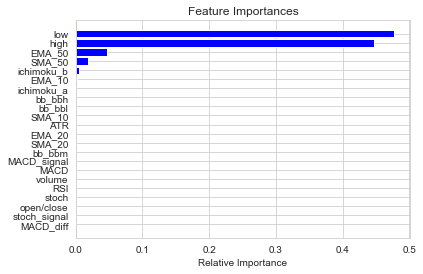

In [55]:
# Create a graph which shows the feature importance that is responsible to the changes of the target (price) column

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [56]:
# Calculate the accuracy of the model using r2_score
r2_score(pred_y,Facebook_validation_set["adjusted close"][1:])

0.9244077063763609

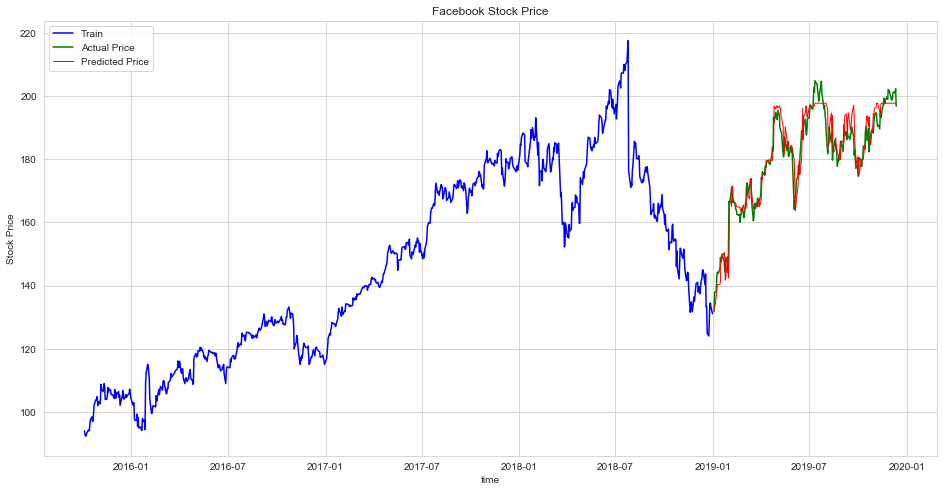

In [57]:
# Returns a graph showing both the predicted (red) and the actual price (green) using the data from 2013-2018 as the training set (blue)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(Facebook_test[800:]["date"],Facebook_test[800:]["adjusted close"], label = 'Train', color="blue")
ax.plot(Facebook_validation_set["date"][1:],Facebook_validation_set["adjusted close"][1:], label = 'Actual Price', color="green")
ax.plot(Facebook_validation_set["date"][1:],pred_y, label = 'Predicted Price', color="red",linewidth=1.0)
ax.set_title("Facebook Stock Price")
ax.set_xlabel('time')
ax.set_ylabel('Stock Price')
ax.legend(loc = 'upper left');

#### LSTM model (Long Short Term Memory)

In [58]:
# import the relevant machine learning modules for LSTM

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [59]:
# Combine X_train and y_train to form a training set

training = X_train.copy()
training["adjusted close"] = y_train

In [60]:
training_LSTM = training.values
training_LSTM

array([[2.40400000e+01, 2.30300000e+01, 2.92859000e+07, ...,
        2.84497456e+01, 3.05388529e+01, 2.17100000e+01],
       [2.33700000e+01, 2.16100000e+01, 5.61794000e+07, ...,
        2.78078651e+01, 3.01926233e+01, 2.08800000e+01],
       [2.15800000e+01, 2.08400000e+01, 4.46044000e+07, ...,
        2.71480684e+01, 2.98274224e+01, 2.00400000e+01],
       ...,
       [1.34240000e+02, 1.25890000e+02, 3.97233700e+07, ...,
        1.36967248e+02, 1.43636892e+02, 1.34520000e+02],
       [1.34990000e+02, 1.29670000e+02, 3.12025090e+07, ...,
        1.36734177e+02, 1.43279367e+02, 1.33200000e+02],
       [1.35920000e+02, 1.32200000e+02, 2.26275690e+07, ...,
        1.36397589e+02, 1.42884098e+02, 1.31090000e+02]])

In [61]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_LSTM_scaled = sc.fit_transform(training_LSTM)

In [62]:
training_LSTM_scaled[:,-1]

array([0.01992782, 0.01577306, 0.01156825, ..., 0.58462439, 0.57801683,
       0.56745474])

In [63]:
X_train_LSTM = training_LSTM_scaled[:,:-1]
y_train_LSTM = training_LSTM_scaled[:,-1]

In [64]:
X_train_LSTM = np.reshape(X_train_LSTM, (X_train_LSTM.shape[0],X_train_LSTM.shape[1],1))

In [65]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_LSTM.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train_LSTM,y_train_LSTM,epochs=150,batch_size=32)

Epoch 1/150
1615/1615 [==============================] - 4s 2ms/step - loss: 0.0295
Epoch 2/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0116
Epoch 3/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0092
Epoch 4/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0079
Epoch 5/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0065
Epoch 6/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 7/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0050
Epoch 8/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0050
Epoch 9/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0046
Epoch 10/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0040
Epoch 11/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0039
Epoch 12/150
1615/1615 [==============================] - 2s 1ms/step - lo

1615/1615 [==============================] - 2s 1ms/step - loss: 0.0012
Epoch 98/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0010
Epoch 99/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 100/150
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 101/150
1615/1615 [==============================] - 2s 2ms/step - loss: 0.0012A: 0s - loss
Epoch 102/150
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0011
Epoch 103/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 104/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 105/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 106/150
1615/1615 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 107/150
1615/1615 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 108/150
1615/1615 [==============================] -

In [66]:
# for testing from 2019-01-01 onwards
# shift the features for one day in order to make stock price predictions based on the information we receive on the day before

y_test= Facebook.iloc[1615:]["adjusted close"][1:]
X_test= Facebook.iloc[1615:][features].shift(1).dropna()

testing_LSTM = X_test.copy()
testing_LSTM["adjusted close"] = y_test

testing_LSTM = testing_LSTM.values

In [67]:
Facebook.iloc[1615:][features].shift(1).dropna()

,high,low,volume,open/close,SMA_10,SMA_20,SMA_50,bb_bbm,bb_bbh,bb_bbl,ATR,RSI,stoch,stoch_signal,MACD,MACD_signal,MACD_diff,ichimoku_a,ichimoku_b,EMA_10,EMA_20,EMA_50
1616,134.6400,129.9500,24625308.0,1.025631,133.249,137.3335,141.6202,137.3335,149.273541,125.393459,5.835170,42.157672,33.388498,41.028824,3.056935,2.685562,0.371373,134.790000,141.75500,133.541703,135.892104,142.421584
1617,137.5100,128.5600,28146193.0,0.950693,132.798,137.0870,141.2354,137.0870,148.949599,125.224401,6.057658,48.126689,52.378982,42.628603,2.702906,2.689030,0.013875,134.535000,141.75500,133.930484,135.871904,142.157208
1618,137.1700,131.1200,22717948.0,1.022393,131.606,136.6195,140.7892,136.6195,148.550984,124.688016,6.057111,43.935468,37.929535,41.232338,2.709032,2.693031,0.016001,132.685000,140.84000,133.532215,135.478389,141.748690
1619,138.0000,133.7500,29002059.0,0.971439,132.077,136.6205,140.4526,136.6205,148.552426,124.688574,6.071603,51.155662,64.941279,51.749932,2.187575,2.591939,-0.404365,132.807500,140.18500,134.335448,135.713780,141.599722
1620,138.8700,135.9100,20089337.0,0.996451,132.542,136.5415,140.1258,136.5415,148.413449,124.669551,5.849346,51.264504,65.604540,56.158451,1.746119,2.422775,-0.676657,133.025000,140.18000,135.010821,135.936278,141.460517
1621,143.1400,139.5400,26263793.0,0.981478,134.300,136.7970,140.0556,136.7970,148.950194,124.643806,5.795107,55.995423,85.159319,71.901712,1.022971,2.142814,-1.119843,134.810000,139.71000,136.377945,136.564251,141.502458
1622,144.7000,141.2700,22205879.0,0.991125,136.317,136.9160,139.9212,136.9160,149.309015,124.522985,5.626171,57.674452,96.893559,82.552472,0.309132,1.776078,-1.466946,135.867500,139.71000,137.805591,137.294322,141.609420
1623,144.5600,140.8400,16125004.0,0.992233,137.319,137.0220,139.8978,137.0220,149.624374,124.419626,5.490015,57.632661,97.693727,93.248868,-0.251273,1.370608,-1.621881,135.867500,139.71000,138.968211,137.952006,141.711012
1624,145.3600,142.5700,12908031.0,0.995480,138.247,136.9870,139.9320,136.9870,149.509743,124.464257,5.297157,57.039190,93.017010,95.868098,-0.655565,0.965373,-1.620938,136.032500,139.71000,139.846718,138.508958,141.792933
1625,146.5700,141.2700,20520278.0,0.976683,139.466,137.0060,139.9154,137.0060,149.578431,124.433569,5.297360,58.852995,94.989384,95.233374,-1.091684,0.553962,-1.645646,136.335000,139.71000,140.854587,139.164295,141.933994


In [68]:
training_LSTM_scaled = sc.fit_transform(testing_LSTM)

In [69]:
# Reshape the testing set as well 
X_test_LSTM = training_LSTM_scaled[:,:-1]
y_actual_LSTM = training_LSTM_scaled[:,-1]

X_test_LSTM = np.reshape(X_test_LSTM, (X_test_LSTM.shape[0],X_test_LSTM.shape[1],1))

In [70]:
predicted_stock_price = regressor.predict(X_test_LSTM)

In [71]:
predicted_stock_price

array([[0.0612174 ],
       [0.05826911],
       [0.05448249],
       [0.06194577],
       [0.06325951],
       [0.08185333],
       [0.09562695],
       [0.10038772],
       [0.09922081],
       [0.10456601],
       [0.11820945],
       [0.12004039],
       [0.11954141],
       [0.13427813],
       [0.13166119],
       [0.12621965],
       [0.12536469],
       [0.13684602],
       [0.13350806],
       [0.12643623],
       [0.14869952],
       [0.24405164],
       [0.25986886],
       [0.28821784],
       [0.3192008 ],
       [0.3384559 ],
       [0.34121174],
       [0.34694496],
       [0.35467103],
       [0.3607785 ],
       [0.3589101 ],
       [0.35671923],
       [0.35610574],
       [0.3508333 ],
       [0.34434292],
       [0.339582  ],
       [0.34011173],
       [0.3489939 ],
       [0.34944695],
       [0.3477863 ],
       [0.3426318 ],
       [0.341485  ],
       [0.36369044],
       [0.3856358 ],
       [0.40234128],
       [0.39616758],
       [0.39804202],
       [0.418

In [72]:
predicted_model = np.append(training_LSTM_scaled[:,:-1],predicted_stock_price,axis=1)

In [73]:
predicted_model.shape

(240, 23)

In [74]:
predicted_model = sc.inverse_transform(predicted_model)

In [75]:
predicted_model[:,-1:].shape

(240, 1)

In [76]:
y_test.shape

(240,)

In [77]:
r2_score(predicted_model[:,-1:],y_test)

0.8014668483814167

In [78]:
Facebook_validation_set["adjusted close"][1:].shape

(239,)

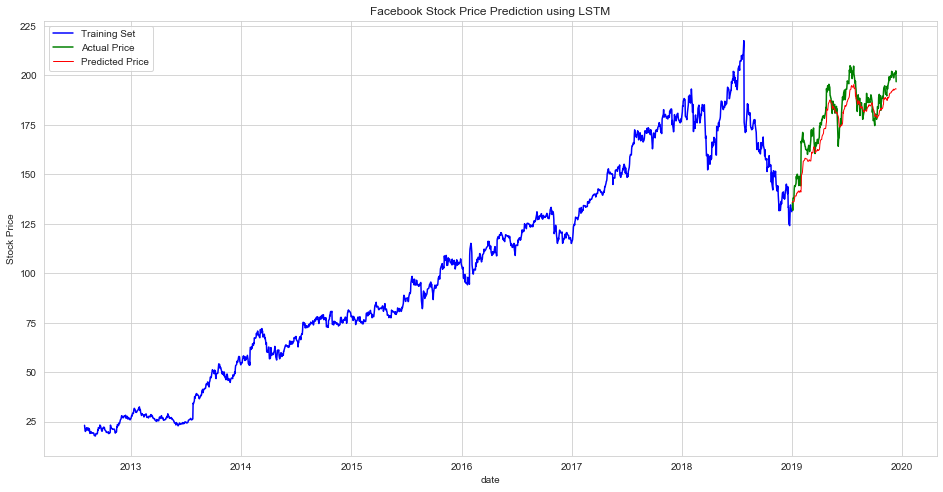

In [79]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(Facebook_test["date"],Facebook_test["adjusted close"], label = 'Training Set', color="blue")
ax.plot(Facebook_validation_set["date"],Facebook_validation_set["adjusted close"], label = 'Actual Price', color="green")
ax.plot(Facebook_validation_set["date"],predicted_model[:,-1:], label = 'Predicted Price', color="red",linewidth=1.0)
ax.set_title("Facebook Stock Price Prediction using LSTM")
ax.set_xlabel('date')
ax.set_ylabel('Stock Price')
ax.legend(loc = 'upper left');

### Visualise the correlation between different features

In [82]:
import seaborn as sns

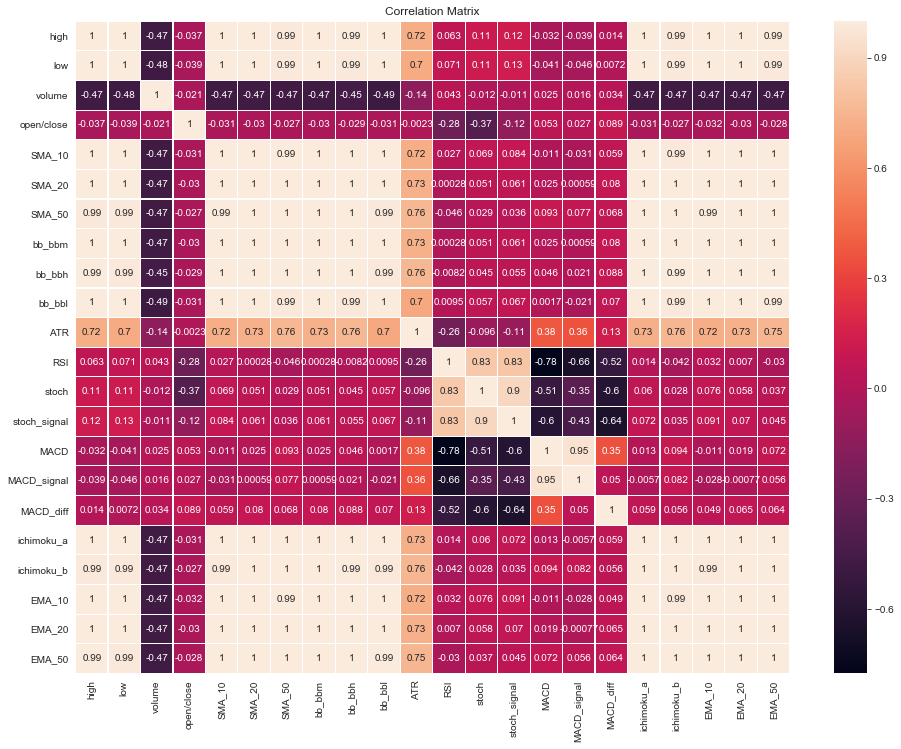

In [83]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(X_train.corr(),
           linewidths=.1,
           vmax=1,
           linecolor="white",
            annot=True,
           ax=ax)

ax.set_title("Correlation Matrix");

# Add these two lines to fix the half square bug
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);